# Debug S2 cube download

In [1]:
import os
from pathlib import Path
import sys

base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent
sys.path.insert(0, str(base_dir))
import earthnet_minicuber as emc

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
from shapely.ops import cascaded_union
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
import zarr
import pickle
import time
import datetime

In [2]:
output_prefix = os.path.expanduser('~/mnt/eo-nas1/data/satellite/sentinel2/raw/CH/')
grid_path = os.path.expanduser(output_prefix) + 'grid_copy.pkl'
grid = pd.read_pickle(grid_path)

In [3]:
patch = grid.iloc[1094].geometry #
n_cells = 6
patch_size = 1280

In [8]:
specs = {
        "lon_lat": (None, None), # center pixel
        "xy_shape": (None, None), # width, height of cutout around center pixel
        "resolution": 10, # in meters.. will use this on a local UTM grid..
        "time_interval": "2023-01-01/2023-12-31",
        "final_epsg": 32632,
        "providers": [
            {
                "name": "s2",
                "kwargs": {
                    "bands": ["AOT", "B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12", "WVP"], 
                    "brdf_correction": True, 
                    "cloud_mask": True, 
                    "correct_processing_baseline": True,
                    "data_source": "planetary_computer"}
            }
            ]
    }

In [9]:
# Update specs 
specs["lon_lat"] = (patch.bounds[0], patch.bounds[-1]) # upper left corner
specs["xy_shape"] = (int(patch_size*(n_cells+1)/specs["resolution"]), int(patch_size*(n_cells+1)/specs["resolution"]))
                

In [11]:
cube = emc.load_minicube(specs, compute=True, verbose=True)

Loading Sentinel2 for 2023-01-01/2023-01-31
Loading Sentinel2 for 2023-02-01/2023-02-28
Loading Sentinel2 for 2023-03-01/2023-03-31
Loading Sentinel2 for 2023-04-01/2023-04-30
Loading Sentinel2 for 2023-05-01/2023-05-31
Loading Sentinel2 for 2023-06-01/2023-06-30
Loading Sentinel2 for 2023-07-01/2023-07-31
Loading Sentinel2 for 2023-08-01/2023-08-31
Loading Sentinel2 for 2023-09-01/2023-09-30
Loading Sentinel2 for 2023-10-01/2023-10-31
Loading Sentinel2 for 2023-11-01/2023-11-30
Loading Sentinel2 for 2023-12-01/2023-12-31


In [12]:
cube

<xarray.Dataset> Size: 14GB
Dimensions:              (time: 564, lat: 896, lon: 896)
Coordinates:
  * time                 (time) datetime64[ns] 5kB 2023-01-02 ... 2023-12-30
  * lon                  (lon) float64 7kB 3.01e+05 3.01e+05 ... 3.1e+05 3.1e+05
  * lat                  (lat) float64 7kB 5.204e+06 5.204e+06 ... 5.195e+06
Data variables: (12/21)
    s2_AOT               (time, lat, lon) uint16 906MB 111 111 111 ... 76 76 76
    s2_B01               (time, lat, lon) uint16 906MB 2196 2196 2196 ... 70 39
    s2_B02               (time, lat, lon) uint16 906MB 2231 2308 2369 ... 0 0 0
    s2_B03               (time, lat, lon) uint16 906MB 2565 2504 2482 ... 0 0 0
    s2_B04               (time, lat, lon) uint16 906MB 2281 2293 2396 ... 0 0 0
    s2_B05               (time, lat, lon) uint16 906MB 3160 3160 3162 ... 0 0 0
    ...                   ...
    s2_mask              (time, lat, lon) uint16 906MB 2 2 2 2 2 2 ... 0 0 0 0 0
    product_uri          (time) <U65 147kB 'S2A_MSIL2A_20230102T104441_N0400_...
    mean_solar_zenith    (time) float32 2kB 71.08 70.19 71.15 ... 71.72 70.85
    mean_solar_azimuth   (time) float32 2kB 71.08 70.19 71.15 ... 71.72 70.85
    mean_sensor_zenith   (time) float32 2kB 10.04 11.07 8.063 ... 6.26 4.714
    mean_sensor_azimuth  (time) float32 2kB 10.04 11.07 8.063 ... 6.26 4.714
Attributes:
    history:                  Created by Sélène Ledain on 2024-06-08 11:25:39...
    source:                   Microsoft Planetary Computer
    grid:                     EPSG:32632. Coordinates are upper left corners ...
    missing data fill value:  65535
    processing:               Baseline correction, cloud masking, BRDF correc...

In [8]:
cube.to_zarr('test.zarr')

# Load downloaded data to check if it's ok

In [2]:
import xarray as xr

In [62]:
data_folder = os.path.expanduser('~/mnt/eo-nas1/data/satellite/sentinel2/raw/CH')
cubes = [f for f in os.listdir(data_folder) if f.endswith('zarr')]

mc = xr.open_zarr('/home/f80873755@agsad.admin.ch/mnt/eo-nas1/data/satellite/sentinel2/raw/CH/S2_441820_5192620_20190102_20191231.zarr')
#os.path.join(data_folder, cubes[-1]))#.compute()

In [63]:
mc = mc.compute()
mc

<xarray.Dataset> Size: 150MB
Dimensions:              (lat: 128, lon: 128, time: 286)
Coordinates:
  * lat                  (lat) float64 1kB 5.193e+06 5.193e+06 ... 5.191e+06
  * lon                  (lon) float64 1kB 4.418e+05 4.418e+05 ... 4.431e+05
  * time                 (time) datetime64[ns] 2kB 2019-01-02 ... 2019-12-31
Data variables: (12/21)
    mean_sensor_azimuth  (time) float32 1kB 8.333 7.17 5.868 ... 5.852 7.686
    mean_sensor_zenith   (time) float32 1kB 8.333 7.17 5.868 ... 5.852 7.686
    mean_solar_azimuth   (time) float32 1kB 71.67 70.79 71.02 ... 71.41 70.52
    mean_solar_zenith    (time) float32 1kB 71.67 70.79 71.02 ... 71.41 70.52
    product_uri          (time) <U65 74kB 'S2B_MSIL2A_20190102T102429_N0212_R...
    s2_AOT               (time, lat, lon) uint16 9MB 73 73 73 73 ... 72 72 72 72
    ...                   ...
    s2_B11               (time, lat, lon) uint16 9MB 729 729 1530 ... 1385 1385
    s2_B12               (time, lat, lon) uint16 9MB 1246 1246 ... 1249 1249
    s2_B8A               (time, lat, lon) uint16 9MB 1048 1048 ... 2234 2234
    s2_SCL               (time, lat, lon) uint16 9MB 10 10 10 10 8 ... 7 7 7 7 7
    s2_WVP               (time, lat, lon) uint16 9MB 472 472 472 ... 454 454 454
    s2_mask              (time, lat, lon) uint16 9MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
Attributes:
    grid:                     EPSG:32632. Coordinates are upper left corners ...
    history:                  Created by Sélène Ledain on 2024-06-06 15:52:23...
    missing data fill value:  65535
    processing:               Baseline correction, cloud masking, BRDF correc...
    source:                   Microsoft Planetary Computer

In [64]:
mc.time

<xarray.DataArray 'time' (time: 286)> Size: 2kB
array(['2019-01-02T00:00:00.000000000', '2019-01-02T00:00:00.000000000',
       '2019-01-05T00:00:00.000000000', ..., '2019-12-28T00:00:00.000000000',
       '2019-12-31T00:00:00.000000000', '2019-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2kB 2019-01-02 2019-01-02 ... 2019-12-31

In [72]:
test = mc.sel(time='2019-01-02T00:00:00.000000000').s2_B02.values

In [78]:
mc.sel(time='2019-01-02T00:00:00.000000000').product_uri

<xarray.DataArray 'product_uri' (time: 2)> Size: 520B
array(['S2B_MSIL2A_20190102T102429_N0212_R065_T32TMT_20201007T221613.SAFE',
       'S2B_MSIL2A_20190102T102429_N0212_R065_T32TMS_20201007T221614.SAFE'],
      dtype='<U65')
Coordinates:
  * time     (time) datetime64[ns] 16B 2019-01-02 2019-01-02

# Check the cloud mask 

In [79]:
# Check cloud mask values where data is missing
rgb_plots = mc[["s2_B04", "s2_B03", "s2_B02"]].to_array("band")
mask = (rgb_plots == 65535).any(dim='band')
s2_mask_values = mc["s2_mask"].where(mask, drop=True)

# Print the result
print(np.unique(s2_mask_values))

[ 4. nan]


In [80]:
# Check number of missing values
rgb_plots = mc[["s2_B04", "s2_B03", "s2_B02"]].to_array("band")
print(np.sum(rgb_plots == 65535))

rgb_plots = rgb_plots.where(rgb_plots != 65535, np.nan)
print(np.sum(rgb_plots.isnull()))

<xarray.DataArray ()> Size: 8B
array(2976)
<xarray.DataArray ()> Size: 8B
array(2976)


In [81]:
# Find dates with most missing (missing among all rgb bands)

rgb = mc[["s2_B04", "s2_B03", "s2_B02"]].to_array('band')
nan_mask = np.isnan(rgb).all(axis=0)
missing_count_per_time = nan_mask.sum(dim=['lat', 'lon'])
missing_time_descending = missing_count_per_time.sortby(missing_count_per_time, ascending=False).time

In [82]:
missing_time_descending

<xarray.DataArray 'time' (time: 286)> Size: 2kB
array(['2019-12-31T00:00:00.000000000', '2019-12-31T00:00:00.000000000',
       '2019-12-28T00:00:00.000000000', ..., '2019-01-05T00:00:00.000000000',
       '2019-01-02T00:00:00.000000000', '2019-01-02T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2kB 2019-12-31 2019-12-31 ... 2019-01-02

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


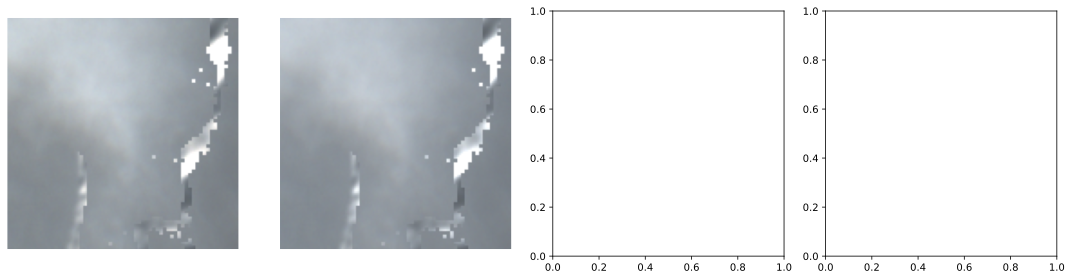

In [83]:

t = '2019-01-05T00:00:00.000000000'
rgb_plots = mc.sel(time=t)[["s2_B04", "s2_B03", "s2_B02"]].to_array("band")
rgb_plots = rgb_plots.where(rgb_plots != 65535, np.nan)
rgb_plots = rgb_plots/10000

# Calculate global min and max for each band
if rgb_plots.ndim == 3:
    global_min = rgb_plots.min(dim=['lat', 'lon'], skipna=True)
    global_max = rgb_plots.max(dim=['lat', 'lon'], skipna=True)
else:
      global_min = rgb_plots.min(dim=['time', 'lat', 'lon'], skipna=True)
      global_max = rgb_plots.max(dim=['time', 'lat', 'lon'], skipna=True)

# Create a custom colormap with white for NaN values
cmap = plt.cm.viridis
cmap.set_bad(color='white')

# Set up the figure and axes
fig, axes = plt.subplots(1, 4, figsize=(15, 1 * 4))
counter = 0

if rgb_plots.ndim ==4: # There are repeated timesteps
      for j in range(rgb_plots.shape[1]):
            
            # Plot the RGB image for the current time step and image
            axes[j].imshow(np.ma.masked_invalid(rgb_plots.values[:, j, :, :].transpose(1, 2, 0)), vmin=0.0, vmax=1, cmap=cmap)
            axes[j].axis('off')  # Turn off axis

            counter += 1
            
if rgb_plots.ndim ==3: # There are no repeated timesteps
      # Plot the RGB image for the current time step and image
      axes[0].imshow(np.ma.masked_invalid(rgb_plots.values.transpose(1, 2, 0)), vmin=0.0, vmax=1, cmap=cmap)
      axes[0].axis('off')  # Turn off axis

      counter += 1


plt.tight_layout()
plt.show()

# Check some cubes

In [24]:
import xarray as xr

ds = xr.open_dataset(os.path.expanduser('~/mnt/eo-nas1/data/satellite/sentinel2/raw/CH/S2_542940_5270700_20200102_20201230.zarr'), engine='zarr').compute()
ds3 = xr.open_dataset(os.path.expanduser('~/mnt/eo-nas1/data/satellite/sentinel2/raw/CH/S2_542940_5270700_20200102_20201225.zarr'), engine='zarr').compute()

In [32]:
ds.isel(time=-1).s2_B02.values

array([[65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       ...,
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535]], dtype=uint16)

# Check download status

In [2]:
df1 = pd.read_pickle(os.path.expanduser('~/mnt/eo-nas1/data/satellite/sentinel2/raw/CH/grid_copy.pkl'))
df2 = pd.read_pickle(os.path.expanduser('~/mnt/eo-nas1/data/satellite/sentinel2/raw/CH/grid_copy2.pkl'))
df3 = pd.read_pickle(os.path.expanduser('~/mnt/eo-nas1/data/satellite/sentinel2/raw/CH/grid_copy3.pkl'))

In [3]:
df1['len'] = df1['years_done'].apply(lambda x: len(x) if x is not None else 0)
print(np.unique(df1['len']))

df2['len'] = df2['years_done'].apply(lambda x: len(x) if x is not None else 0)
print(np.unique(df2['len']))

df3['len'] = df3['years_done'].apply(lambda x: len(x) if x is not None else 0)
print(np.unique(df3['len']))

[0 7]
[0 7]
[0 7]


In [4]:
# Count downloads per grid cell

data_path = os.path.expanduser('~/mnt/eo-nas1/data/satellite/sentinel2/raw/CH')
data_files = [f for f in os.listdir(data_path) if f.endswith('zarr')]
df_zarr = pd.DataFrame(data_files, columns=['file'])

In [5]:
def extract_minx_maxy(file):
    parts = file.split('_')
    minx = int(parts[1])
    maxy = int(parts[2])
    return minx, maxy

# Apply the function to extract minx and maxy into new columns
df_zarr[['minx', 'maxy']] = df_zarr['file'].apply(lambda x: pd.Series(extract_minx_maxy(x)))

In [6]:
np.unique(df_zarr.groupby(['minx', 'maxy']).count())

array([ 7,  8, 10, 11, 14])

In [12]:
# Group by minx and maxy and count the occurrences
grouped = df_zarr.groupby(['minx', 'maxy']).size().reset_index(name='count')

# Filter the groups where the count is greater than 7
filtered_groups = grouped[grouped['count'] > 7]

# Merge this filtered result back to the original DataFrame to get the actual files
result_df = df_zarr.merge(filtered_groups, on=['minx', 'maxy'])

# Drop the temporary columns if not needed
#result_df = result_df.drop(columns=['minx', 'maxy', 'count'])

In [13]:
result_df

file    minx     maxy  count
0     S2_541660_5252780_20170107_20171231.zarr  541660  5252780     14
1     S2_541660_5252780_20210101_20211230.zarr  541660  5252780     14
2     S2_541660_5252780_20230101_20231230.zarr  541660  5252780     14
3     S2_541660_5252780_20180102_20181231.zarr  541660  5252780     14
4     S2_541660_5252780_20190102_20191231.zarr  541660  5252780     14
...                                        ...     ...      ...    ...
1205  S2_549340_5218220_20210101_20211227.zarr  549340  5218220      8
1206  S2_549340_5218220_20220101_20221227.zarr  549340  5218220      8
1207  S2_549340_5218220_20230101_20231227.zarr  549340  5218220      8
1208  S2_549340_5218220_20190102_20191228.zarr  549340  5218220      8
1209  S2_549340_5218220_20200102_20201227.zarr  549340  5218220      8

[1210 rows x 4 columns]

In [14]:
result_df['maxx'] = result_df['minx'].apply(lambda x: x+1280)
result_df['miny'] = result_df['maxy'].apply(lambda x: x-1280)

result_df.rename(columns={'minx': 'left', 'miny': 'bottom', 'maxx': 'right', 'maxy': 'top'}, inplace=True)
result_df.drop_duplicates(subset=['left', 'top', 'bottom', 'right'], keep='first', inplace=True)
result_df['duplicate'] = True

merged = df1.merge(result_df, on=['left', 'right', 'top', 'bottom'], how='left')
merged['duplicate'] = merged['duplicate'].fillna(False)

In [17]:
gpd.GeoDataFrame(merged, geometry='geometry').plot(column='duplicate')

/home/f80873755@agsad.admin.ch/virtualenvs/10_cropcoveo/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

# Delete duplicate cubes
- Keep the one with the longest dates

In [18]:
# Count downloads per grid cell

data_path = os.path.expanduser('~/mnt/eo-nas1/data/satellite/sentinel2/raw/CH')
data_files = [f for f in os.listdir(data_path) if f.endswith('zarr')]
df_zarr = pd.DataFrame(data_files, columns=['file'])

def extract_minx_maxy(file):
    parts = file.split('_')
    minx = int(parts[1])
    maxy = int(parts[2])
    yr = int(parts[3][:4])
    return minx, maxy, yr

# Find files where more than 2 per year and coord

df_zarr[['minx', 'maxy', 'yr']] = df_zarr['file'].apply(lambda x: pd.Series(extract_minx_maxy(x)))
grouped = df_zarr.groupby(['minx', 'maxy', 'yr']).size().reset_index(name='count')
filtered_groups = grouped[grouped['count'] > 1]
result_df = df_zarr.merge(filtered_groups, on=['minx', 'maxy', 'yr'])
result_df = result_df.drop(columns=['count'])

In [19]:
result_df

file    minx     maxy    yr
0    S2_541660_5252780_20170107_20171231.zarr  541660  5252780  2017
1    S2_541660_5252780_20170107_20171228.zarr  541660  5252780  2017
2    S2_542940_5252780_20170107_20171231.zarr  542940  5252780  2017
3    S2_542940_5252780_20170107_20171228.zarr  542940  5252780  2017
4    S2_544220_5252780_20170107_20171231.zarr  544220  5252780  2017
..                                        ...     ...      ...   ...
889  S2_546780_5218220_20200102_20201227.zarr  546780  5218220  2020
890  S2_548060_5218220_20200102_20201222.zarr  548060  5218220  2020
891  S2_548060_5218220_20200102_20201227.zarr  548060  5218220  2020
892  S2_549340_5218220_20200102_20201222.zarr  549340  5218220  2020
893  S2_549340_5218220_20200102_20201227.zarr  549340  5218220  2020

[894 rows x 4 columns]

In [20]:
# Find name of file to drop: the one with the shortest dates

def extract_dates(file):
    parts = file.split('_')
    startdate = int(parts[3])
    enddate = int(parts[4].split('.')[0])
    return startdate, enddate

result_df[['startdate', 'enddate']] = result_df['file'].apply(lambda x: pd.Series(extract_dates(x)))

max_enddate_indices = result_df.groupby(['minx', 'maxy', 'yr'])['enddate'].idxmax()
files_not_max_enddate = result_df[~result_df.index.isin(max_enddate_indices)]

In [21]:
files_not_max_enddate

file    minx     maxy    yr  \
1    S2_541660_5252780_20170107_20171228.zarr  541660  5252780  2017   
3    S2_542940_5252780_20170107_20171228.zarr  542940  5252780  2017   
5    S2_544220_5252780_20170107_20171228.zarr  544220  5252780  2017   
7    S2_541660_5251500_20170107_20171228.zarr  541660  5251500  2017   
9    S2_542940_5251500_20170107_20171228.zarr  542940  5251500  2017   
..                                        ...     ...      ...   ...   
884  S2_548060_5219500_20200102_20201222.zarr  548060  5219500  2020   
886  S2_549340_5219500_20200102_20201222.zarr  549340  5219500  2020   
888  S2_546780_5218220_20200102_20201222.zarr  546780  5218220  2020   
890  S2_548060_5218220_20200102_20201222.zarr  548060  5218220  2020   
892  S2_549340_5218220_20200102_20201222.zarr  549340  5218220  2020   

     startdate   enddate  
1     20170107  20171228  
3     20170107  20171228  
5     20170107  20171228  
7     20170107  20171228  
9     20170107  20171228  
..         ...       ...  
884   20200102  20201222  
886   20200102  20201222  
888   20200102  20201222  
890   20200102  20201222  
892   20200102  20201222  

[447 rows x 6 columns]

#### Compare files to delete with others

In [122]:
times = []
data_path = os.path.expanduser('~/mnt/eo-nas1/data/satellite/sentinel2/raw/CH/')

for f in files_not_max_enddate.file:
  timelen = len(xr.open_dataset(data_path + f, engine='zarr').compute().time)
  times += [timelen]

In [124]:
files_not_max_enddate['times'] = times

/tmp/ipykernel_3101678/940115937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  files_not_max_enddate['times'] = times


In [149]:
files_not_max_enddate

file    minx     maxy    yr  \
1    S2_541660_5252780_20170107_20171228.zarr  541660  5252780  2017   
3    S2_542940_5252780_20170107_20171228.zarr  542940  5252780  2017   
5    S2_544220_5252780_20170107_20171228.zarr  544220  5252780  2017   
7    S2_541660_5251500_20170107_20171228.zarr  541660  5251500  2017   
9    S2_542940_5251500_20170107_20171228.zarr  542940  5251500  2017   
..                                        ...     ...      ...   ...   
884  S2_548060_5219500_20200102_20201222.zarr  548060  5219500  2020   
886  S2_549340_5219500_20200102_20201222.zarr  549340  5219500  2020   
888  S2_546780_5218220_20200102_20201222.zarr  546780  5218220  2020   
890  S2_548060_5218220_20200102_20201222.zarr  548060  5218220  2020   
892  S2_549340_5218220_20200102_20201222.zarr  549340  5218220  2020   

     startdate   enddate  times  
1     20170107  20171228     49  
3     20170107  20171228     49  
5     20170107  20171228     49  
7     20170107  20171228     49  
9     20170107  20171228     49  
..         ...       ...    ...  
884   20200102  20201222     71  
886   20200102  20201222     71  
888   20200102  20201222     71  
890   20200102  20201222     71  
892   20200102  20201222     71  

[447 rows x 7 columns]

In [157]:
ds = xr.open_dataset(data_path + 'S2_545500_5193900_20170107_20171228.zarr', engine='zarr').compute()

In [166]:
result_df[result_df['file'].str.contains('S2_537820_5133740')]

file    minx     maxy    yr  \
0    S2_541660_5252780_20170107_20171231.zarr  541660  5252780  2017   
1    S2_541660_5252780_20170107_20171228.zarr  541660  5252780  2017   
2    S2_542940_5252780_20170107_20171231.zarr  542940  5252780  2017   
3    S2_542940_5252780_20170107_20171228.zarr  542940  5252780  2017   
4    S2_544220_5252780_20170107_20171231.zarr  544220  5252780  2017   
..                                        ...     ...      ...   ...   
889  S2_546780_5218220_20200102_20201227.zarr  546780  5218220  2020   
890  S2_548060_5218220_20200102_20201222.zarr  548060  5218220  2020   
891  S2_548060_5218220_20200102_20201227.zarr  548060  5218220  2020   
892  S2_549340_5218220_20200102_20201222.zarr  549340  5218220  2020   
893  S2_549340_5218220_20200102_20201227.zarr  549340  5218220  2020   

     startdate   enddate  
0     20170107  20171231  
1     20170107  20171228  
2     20170107  20171231  
3     20170107  20171228  
4     20170107  20171231  
..         ...       ...  
889   20200102  20201227  
890   20200102  20201222  
891   20200102  20201227  
892   20200102  20201222  
893   20200102  20201227  

[894 rows x 6 columns]

In [ ]:
import os

# Example list of file paths to delete
files_to_delete = [
    '/path/to/file1.txt',
    '/path/to/file2.txt',
    '/path/to/file3.txt'
]

# Iterate over the list and delete each file
for file_path in files_to_delete:
    try:
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error deleting {file_path}: {e}")